## Denoiser

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model, load_model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import mlflow

In [95]:
import datetime
import platform

from pathlib import Path
from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util as yass_util
from yass.augment import make, util
from yass.augment.noise import noise_cov
from yass.neuralnetwork import evaluate
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import TemplatesProcessor

import numpy as np
from scipy.io import loadmat

from dstools import plot, reproducibility

# logging.basicConfig(level=logging.DEBUG)
savefig = False

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

mlflow.set_tracking_uri(str(Path(path_to_data, 'mlruns')))

In [6]:
import glob
import yaml

path_to_mlflow = '/home/Edu/data/mlruns'
meta = glob.glob(str(Path(path_to_mlflow, '**/meta.yaml')))

def load_yaml(path):
    with open(path) as f:
        content = yaml.load(f)
    return content

experiments = [load_yaml(p) for p in meta]

def get_id_for_experiment_with_name(name):
    matches = [e['experiment_id'] for e in experiments if e['name'] == name]
    if len(matches):
        return matches[0]
    else:
        return mlflow.create_experiment(name)

experiment_name = 'denoiser'
EXPERIMENT_ID = get_id_for_experiment_with_name(experiment_name)
N_CHANNELS = 7

In [7]:
print('Running YASS version: {}\nExperiment: {}'
      .format(yass_util.get_version(), experiment_name))

Running YASS version: 01bd23e min shift param is now passed through collided params
Experiment: denoiser


In [8]:
yass.set_config("../config/gcloud/49/default.yaml", 'tmp')

CONFIG = read_config()

## Load training set

In [1]:
from  mlflow.tracking import MlflowClient
client = MlflowClient()
experiments = client.list_experiments() 
experiment = client.get_experiment_by_name('denoiser-training-set')
training_set_runs = client.list_run_infos(experiment.experiment_id)

AttributeError: 'NoneType' object has no attribute 'experiment_id'

In [10]:
selected = [run for run in training_set_runs if run.run_uuid == '4bc82282d1254434ba0d8226a87d0b87'][0]

In [11]:
training_set_runs[0].artifact_uri

'/home/Edu/data/mlruns/1/98bd022093964128979d95145feaff35/artifacts'

In [12]:
path_to_training_set = Path(selected.artifact_uri, 'dataset.npz')

In [13]:
dataset = np.load(path_to_training_set)

In [14]:
x_train_noisy = dataset['x_train_noisy']
x_train_clean = dataset['x_train_clean']
x_test_noisy = dataset['x_test_noisy']
x_test_clean = dataset['x_test_clean']

In [15]:
selected = np.random.randint(x_test_noisy.shape[0], size=10)

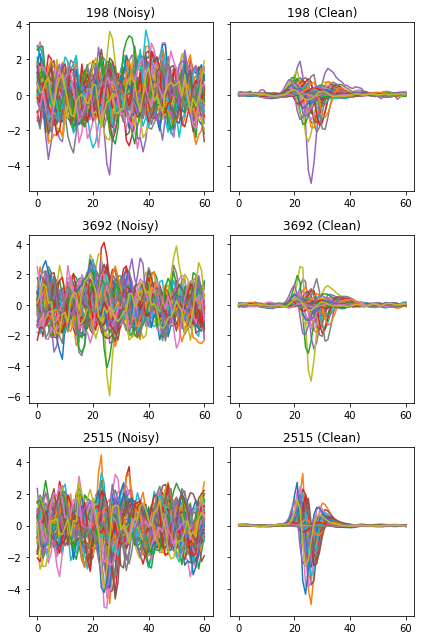

In [16]:
plot.grid_from_array([x_test_noisy,
                      x_test_clean],
                     axis=0,
                     group_names=('Noisy', 'Clean'),
                     elements=selected[:3],
                     auto_figsize=3,
                     sharey='row')

In [17]:
idx = np.random.randint(x_test_noisy.shape[0], size=1)[0]
spike = x_test_clean[idx]
repeated = np.repeat(spike[np.newaxis, :, :], repeats=100, axis=0)
repeated_noisy = util.add_noise(repeated, dataset['spatial_sig'], dataset['temporal_sig'])

In [18]:
if N_CHANNELS:
    x_train_noisy = (TemplatesProcessor(x_train_noisy)
                     .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
                     .values)
    x_train_clean = (TemplatesProcessor(x_train_clean)
                     .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
                     .values)
    x_test_noisy = (TemplatesProcessor(x_test_noisy)
                     .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
                     .values)
    x_test_clean = (TemplatesProcessor(x_test_clean)
                     .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
                     .values)
    
    repeated = (TemplatesProcessor(repeated)
                .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
                .values)
    
    repeated_noisy = (TemplatesProcessor(repeated_noisy)
                     .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
                     .values)

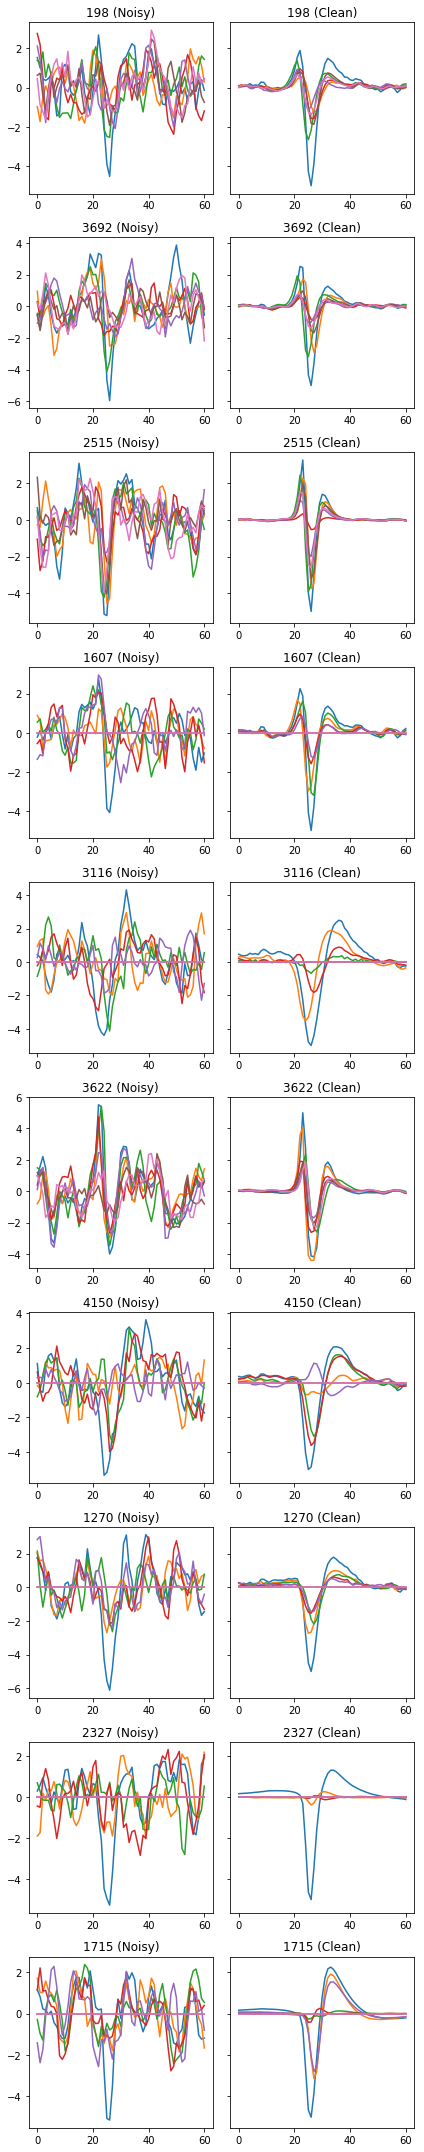

In [19]:
plot.grid_from_array([x_test_noisy,
                      x_test_clean],
                     axis=0,
                     group_names=('Noisy', 'Clean'),
                     elements=selected,
                     auto_figsize=3,
                     sharey='row')

## PCA

In [20]:
x_train_noisy.shape, x_test_noisy.shape

((10080, 61, 7), (4320, 61, 7))

In [21]:
from sklearn.decomposition import PCA

pca = PCA(0.50).fit(x_train_noisy.reshape((len(x_train_noisy), -1)))
pca.n_components_

28

In [22]:
components = pca.transform(x_test_noisy.reshape((len(x_test_noisy), -1)))
x_test_denoised_pca = pca.inverse_transform(components).reshape(x_test_noisy.shape)

In [23]:
residual_pca = x_test_denoised_pca - x_test_clean

In [24]:
np.mean(residual_pca ** 2)

0.5195358722565145

In [25]:
# worst we can do...
np.mean((x_test_clean - x_test_noisy) ** 2)

1.0338970909262657

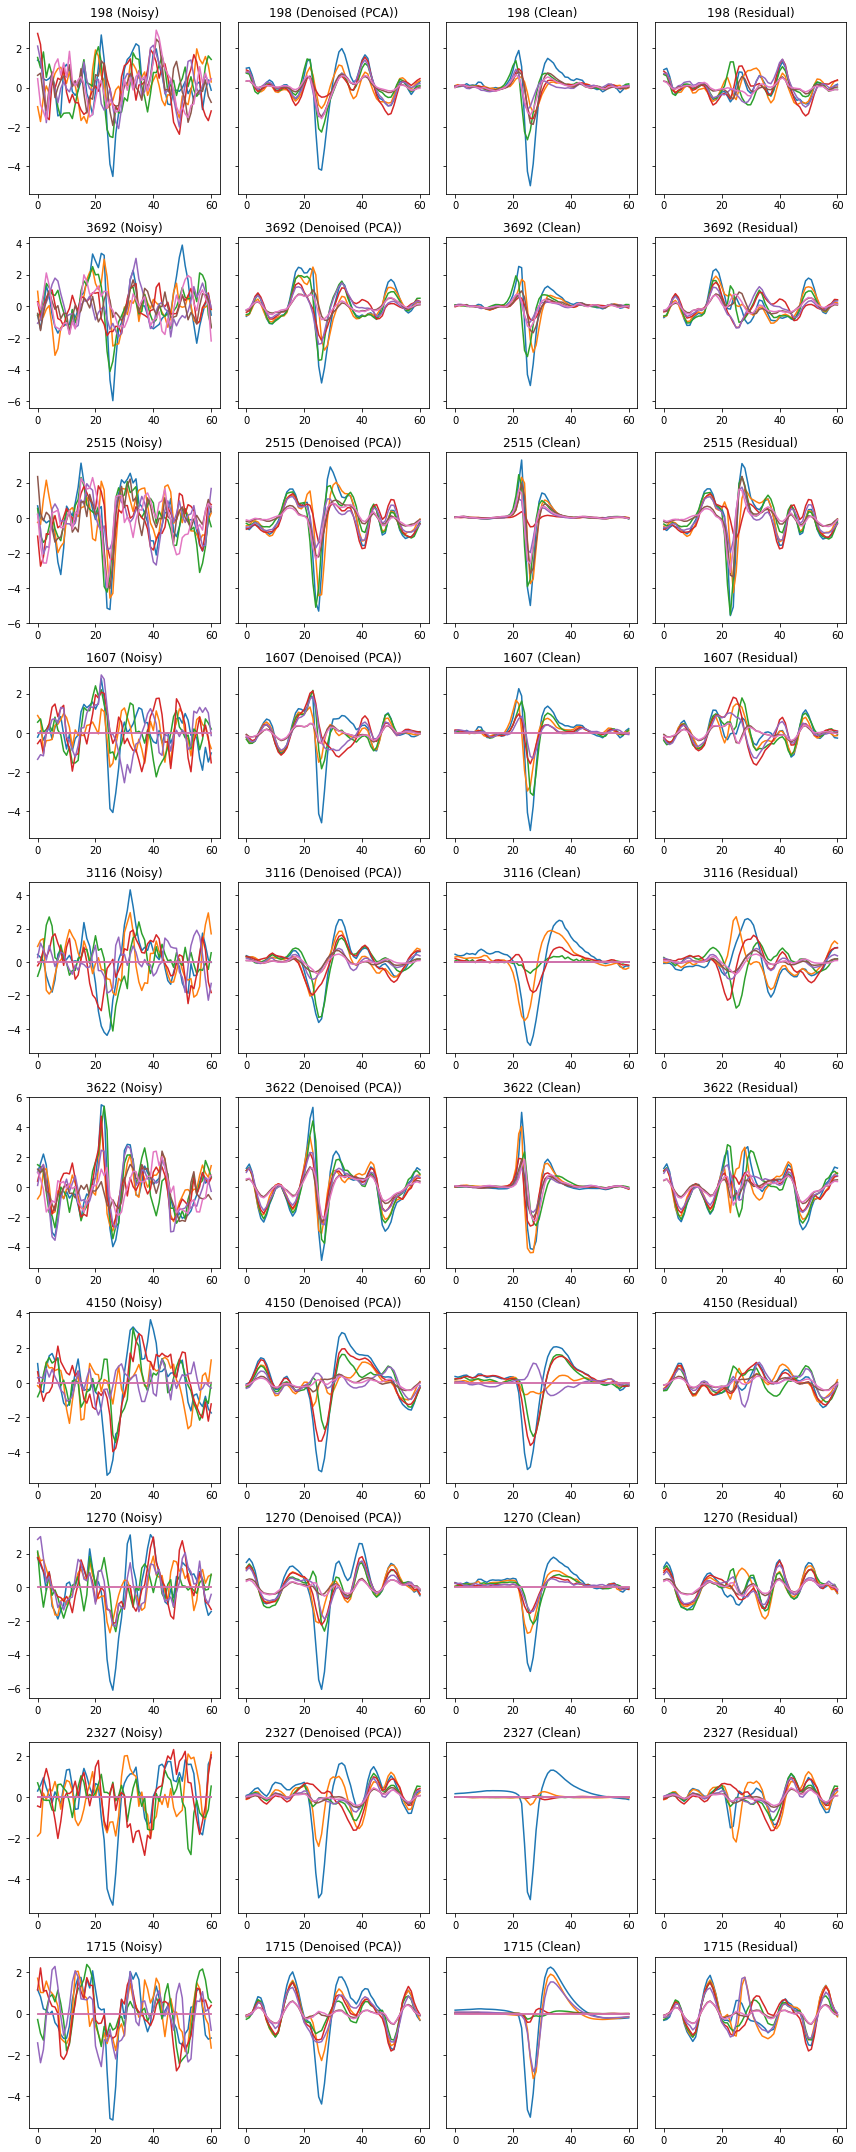

In [26]:
plot.grid_from_array([x_test_noisy,
                      x_test_denoised_pca,
                      x_test_clean,
                     residual_pca],
                     axis=0,
                     group_names=('Noisy', 'Denoised (PCA)', 'Clean', 'Residual'),
                     elements=selected,
                     auto_figsize=3,
                     sharey='row')

In [118]:
from keras.layers import Concatenate, Reshape

n_spikes, waveform_length, n_neighbors = x_train_clean.shape

# Network parameters
input_shape = (waveform_length, n_neighbors, 1)
batch_size = 512
kernel_size = 3
latent_dim = 40

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 16, 32, 16, 32, 16, 32]
n_layers = len(layer_filters)

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=1,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)


# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

connect_input = False

if connect_input:
    latent_inputs = Input(shape=(latent_dim + waveform_length * n_neighbors,), name='decoder_input')
else:
    # Build the Decoder Model
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)


# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for i, filters in enumerate(layer_filters[::-1], 1):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=1,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('linear', name='decoder_output')(x)


# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 61, 7, 1)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 7, 32)         320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 61, 7, 16)         4624      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 7, 32)         4640      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 61, 7, 16)         4624      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 61, 7, 32)         4640      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 7, 16)         4624      
__________

## Training

In [123]:
# Train or loadthe autoencoder
# model_to_load = '25-Jul-2018@23-49-01.h5'
model_to_load = None

# Training parameters
epochs = 20
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)]
# callbacks = []

if model_to_load:
    autoencoder = load_model(model_to_load)
    print('Loaded {}'.format(model_to_load))
else:
    history = autoencoder.fit(x_train_noisy[:, :, :, np.newaxis],
                              x_train_clean[:, :, :, np.newaxis],
                              validation_data=(x_test_noisy[:, :, :, np.newaxis],
                                               x_test_clean[:, :, :, np.newaxis]),
                              epochs=epochs,
                              callbacks=callbacks,
                              batch_size=batch_size)

Train on 10080 samples, validate on 4320 samples
Epoch 1/20
10080/10080 [==============================] - 4s 371us/step - loss: 0.0034 - val_loss: 0.0237
Epoch 2/20
10080/10080 [==============================] - 4s 354us/step - loss: 0.0033 - val_loss: 0.0254
Epoch 3/20
10080/10080 [==============================] - 4s 353us/step - loss: 0.0038 - val_loss: 0.0237
Epoch 4/20
10080/10080 [==============================] - 4s 355us/step - loss: 0.0034 - val_loss: 0.0235
Epoch 5/20
10080/10080 [==============================] - 4s 355us/step - loss: 0.0032 - val_loss: 0.0236
Epoch 6/20
10080/10080 [==============================] - 4s 356us/step - loss: 0.0037 - val_loss: 0.0244
Epoch 7/20
10080/10080 [==============================] - 4s 356us/step - loss: 0.0034 - val_loss: 0.0244
Epoch 8/20
10080/10080 [==============================] - 4s 356us/step - loss: 0.0034 - val_loss: 0.0248
Epoch 9/20
10080/10080 [==============================] - 4s 355us/step - loss: 0.0036 - val_loss: 0.02

0.0234

best val_loss: 0.0551, 2018-09-26T16-06-20:h5

## Denoising (simulated) patches


In [124]:
def predict(model, x):
    x = x[:, :, :, np.newaxis]
    predictions = model.predict(x)
    return np.squeeze(predictions)

In [125]:
x_test_denoised = predict(autoencoder, np.squeeze(x_test_noisy))

In [126]:
residual = x_test_denoised - x_test_clean

In [127]:
np.mean(residual ** 2)

0.023351121765435825

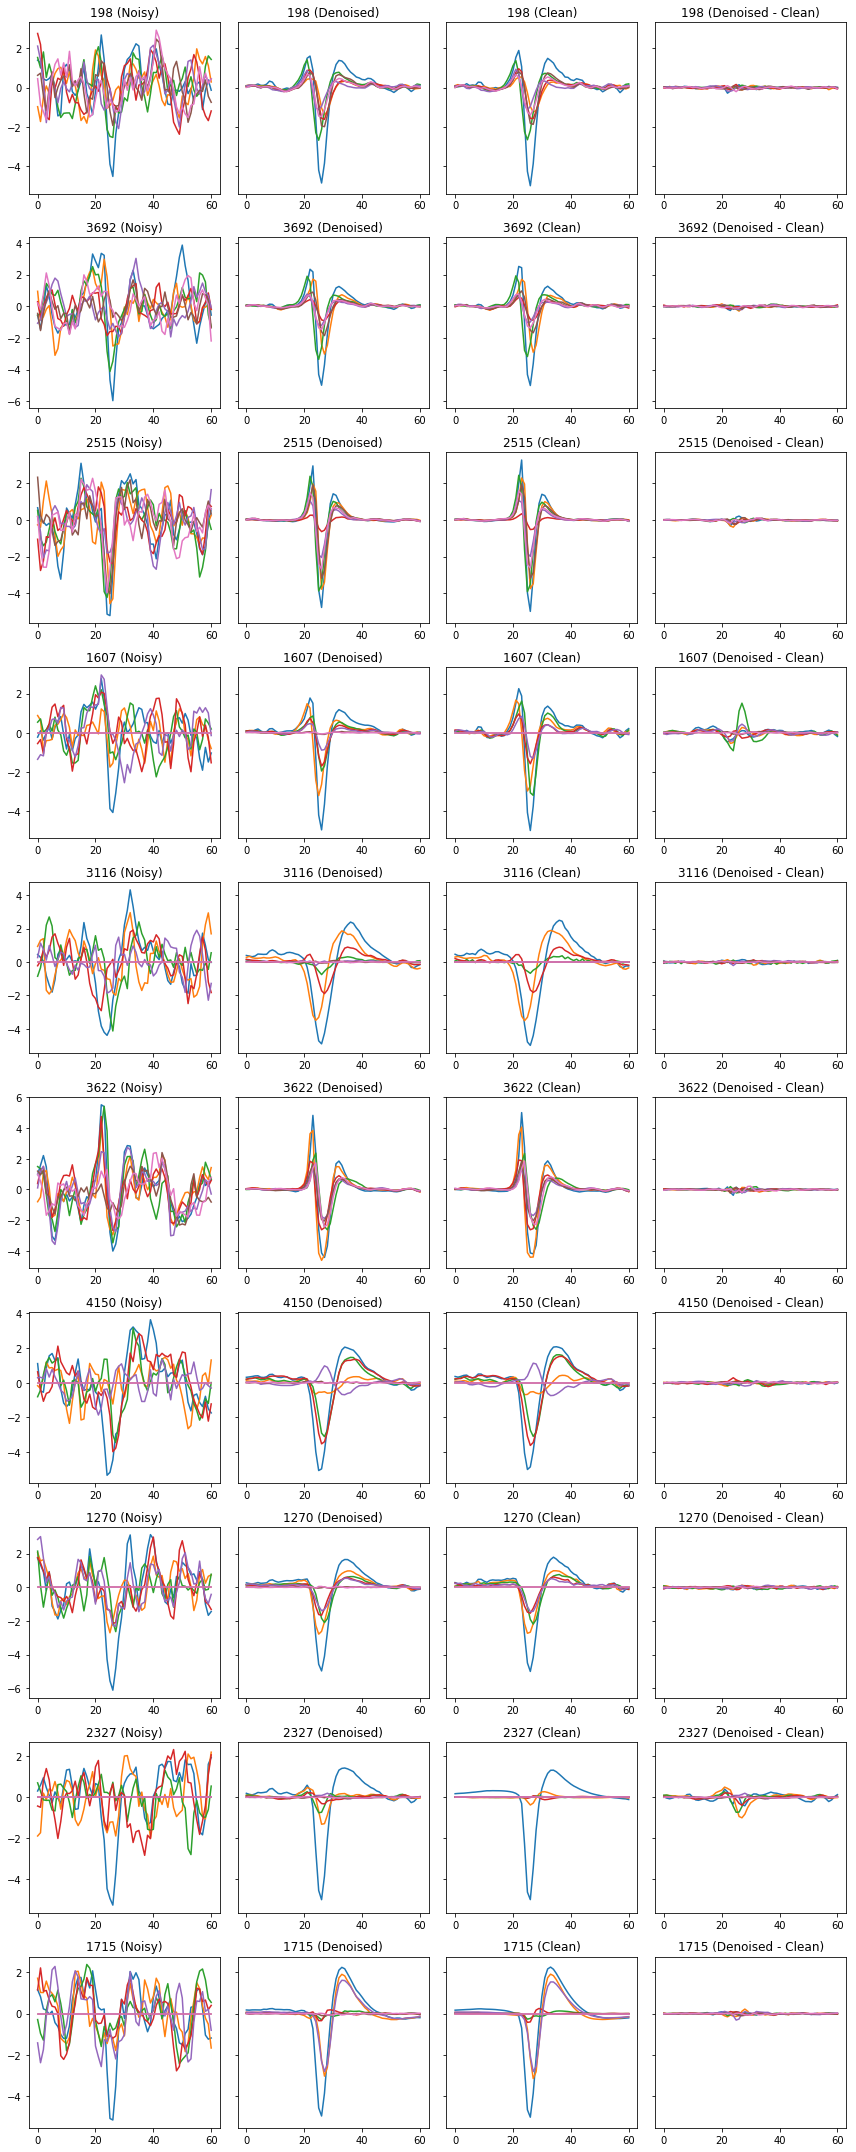

In [128]:
plot.grid_from_array([np.squeeze(x_test_noisy),
                      x_test_denoised,
                      np.squeeze(x_test_clean),
                      residual],
                     axis=0,
                     group_names=('Noisy', 'Denoised', 'Clean', 'Denoised - Clean'),
                     elements=selected,
                     auto_figsize=3,
                     sharey='row')

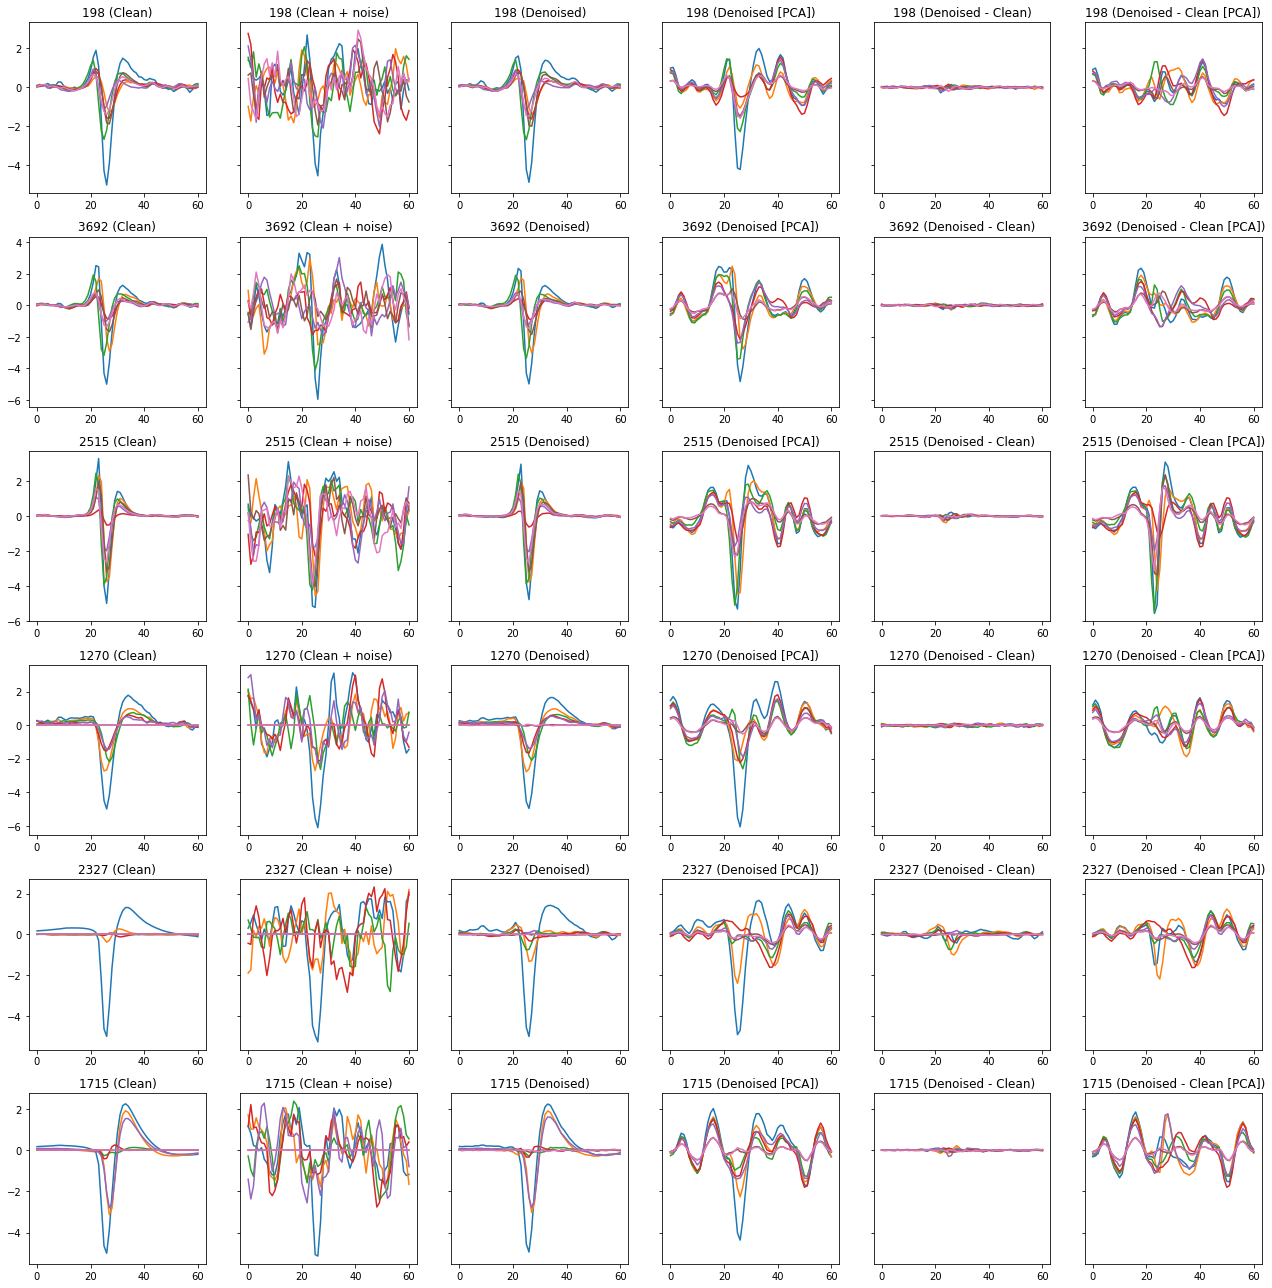

In [129]:
arrs = [np.squeeze(x_test_clean), np.squeeze(x_test_noisy),
       x_test_denoised, x_test_denoised_pca,
       residual, residual_pca]

groups = ['Clean', 'Clean + noise', 'Denoised', 'Denoised [PCA]', 'Denoised - Clean', 'Denoised - Clean [PCA]']

plot.grid_from_array(arrs,
                     axis=0,
                     group_names=groups,
                     elements=selected[[0, 1, 2, 7, 8, 9]],
                     auto_figsize=3,
                     sharey='row')


if savefig:
    filename = reproducibility.make_filename(extension='png')
    plt.savefig(Path(path_to_data, 'denoiser', 'figs', filename))

## Best/worst denoised

In [130]:
errors = np.square(residual ** 2).sum(axis=(1, 2))

In [131]:
errors_sorted_idx = np.argsort(errors)

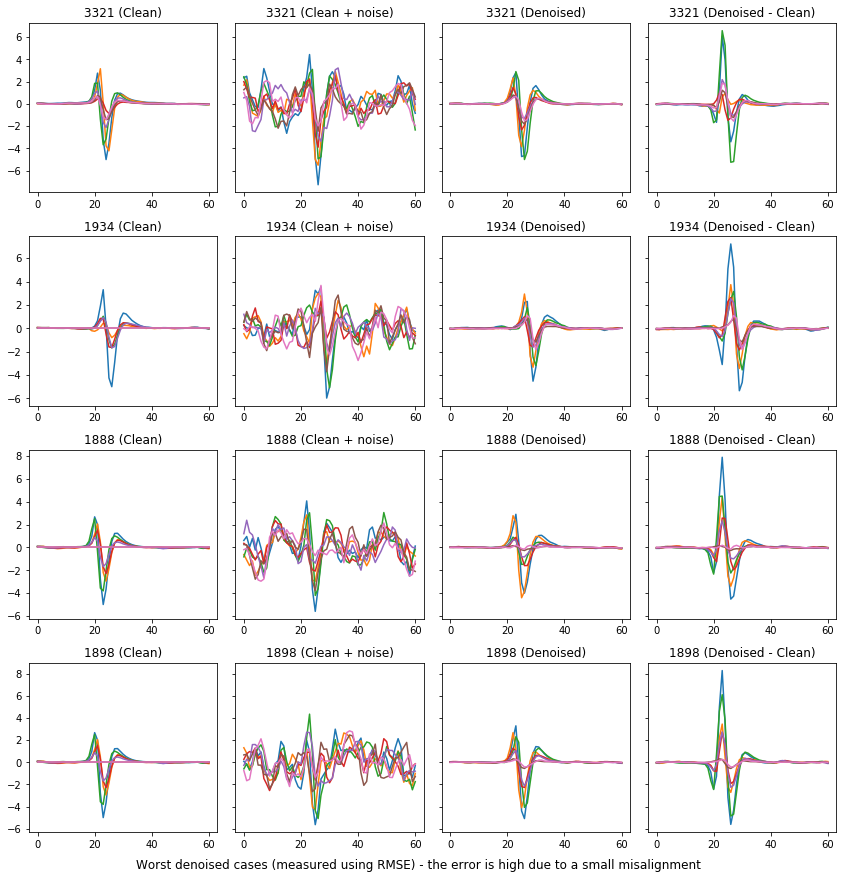

In [132]:
plot.grid_from_array([np.squeeze(x_test_clean),
                      np.squeeze(x_test_noisy),
                      x_test_denoised,
                      residual],
                     axis=0,
                     group_names=('Clean', 'Clean + noise', 'Denoised', 'Denoised - Clean'),
                     elements=errors_sorted_idx[-4:],
                     auto_figsize=3,
                     sharey='row',
                     auto_tight_layout=False)

txt = "Worst denoised cases (measured using RMSE) - the error is high due to a small misalignment"
_ = plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
_ = plt.tight_layout()

if savefig:
    filename = 'worst.png'
    plt.savefig(Path(path_to_data, 'denoiser', 'figs', filename))

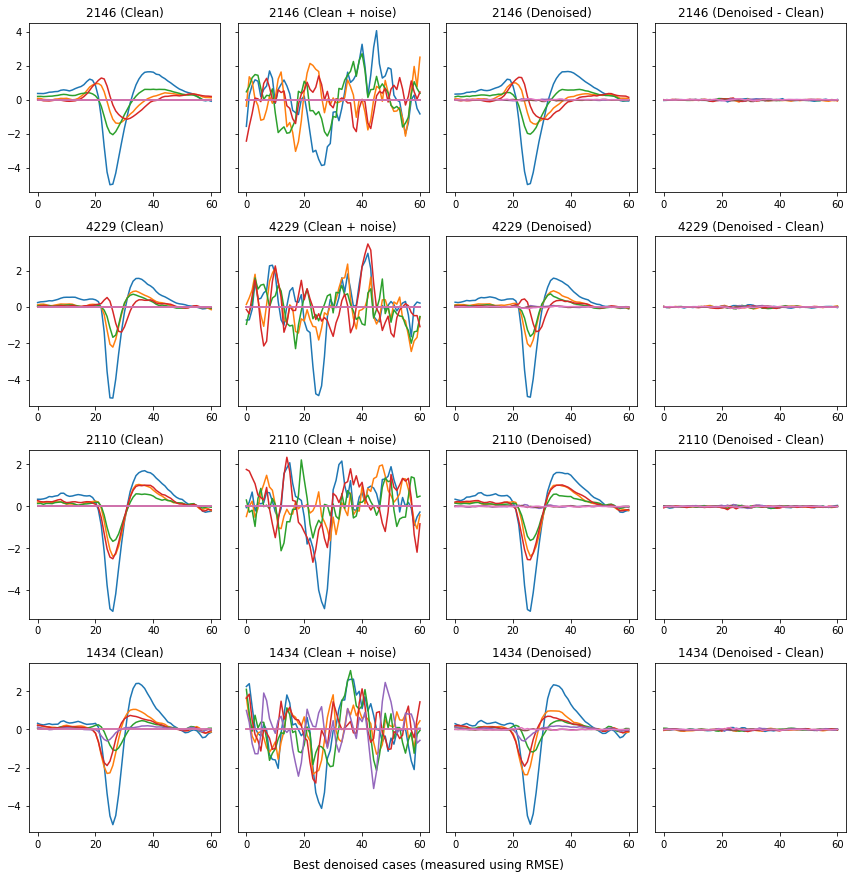

In [133]:
plot.grid_from_array([np.squeeze(x_test_clean),
                      np.squeeze(x_test_noisy),
                      x_test_denoised,
                      residual],
                     axis=0,
                     group_names=('Clean', 'Clean + noise', 'Denoised','Denoised - Clean'),
                     elements=errors_sorted_idx[:4],
                     auto_figsize=3,
                     sharey='row')

txt = "Best denoised cases (measured using RMSE)"
_ = plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
_ = plt.tight_layout()

if savefig:
    filename = 'best.png'
    plt.savefig(Path(path_to_data, 'denoiser', 'figs', filename))

## Denoising the same spike with different noise

In [134]:
repeated_denoised = predict(autoencoder, repeated_noisy)
residual = repeated_denoised - repeated

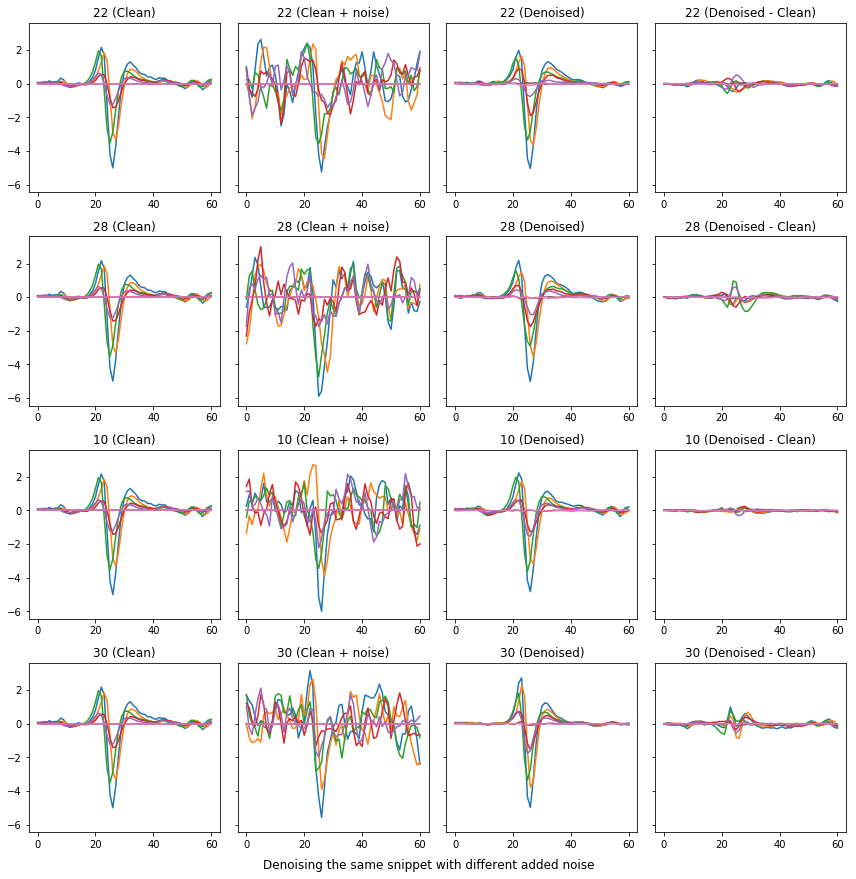

In [135]:
plot.grid_from_array([repeated,
                      repeated_noisy,
                      repeated_denoised,
                      residual],
                     axis=0,
                     group_names=('Clean', 'Clean + noise', 'Denoised', 'Denoised - Clean'),
                     elements=4,
                     auto_figsize=3,
                     sharey=True)

txt = "Denoising the same snippet with different added noise"
_ = plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
_ = plt.tight_layout()


if savefig:
    filename = 'diff-noise.png'
    plt.savefig(Path(path_to_data, 'denoiser', 'figs', filename))

In [61]:
def plot_from_indexes(dataset, model, idxs):
    sub_noisy = np.stack(test_set.df_noisy[idxs].waveform.values)
    sub_clean = np.stack(test_set.df_clean[idxs].waveform.values)
    sbu_denoised = predict(model, sub_clean)

    plot.grid_from_array([sub_noisy,
                          sbu_denoised,
                          sub_clean],
                         axis=0,
                         group_names=('Noisy', 'Denoised', 'Clean'),
                         elements=5,
                         figsize=(10, 10),
                         sharey='row')

In [62]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'zero')

NameError: name 'test_set' is not defined

In [ ]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'collided')

In [ ]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'temporally misaligned')

In [ ]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'spatially misaligned')

In [ ]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'from templates')

## Saving files

In [57]:
x_test_clean.shape, x_test_noisy.shape, x_test_denoised.shape                

((4320, 61, 7), (4320, 61, 7), (4320, 61, 7))

In [60]:
path_to_out = Path(path_to_data, 'denoiser', 'denoised_data.npz')

In [61]:
np.savez(path_to_out, clean=x_test_clean, noisy=x_test_noisy, denoised=x_test_denoised)

## Denoising recordings

In [124]:
exp = RecordingExplorer(path_to_standarized)

In [192]:
patch_size = 61
n_patches = 5
offset = 150000

In [193]:
idxs = [(n * patch_size + offset, (n + 1) * patch_size + offset) for n in range(n_patches)]

In [194]:
patches = np.empty((n_patches, patch_size, 49, 1))

for i, (from_, to_) in enumerate(idxs):
    patches[i, :, :, 0] = exp.reader[from_:to_, :]

In [195]:
patches_denoised = np.squeeze(autoencoder.predict(patches))

In [196]:
patches_denoised = patches_denoised.reshape(-1, 49)

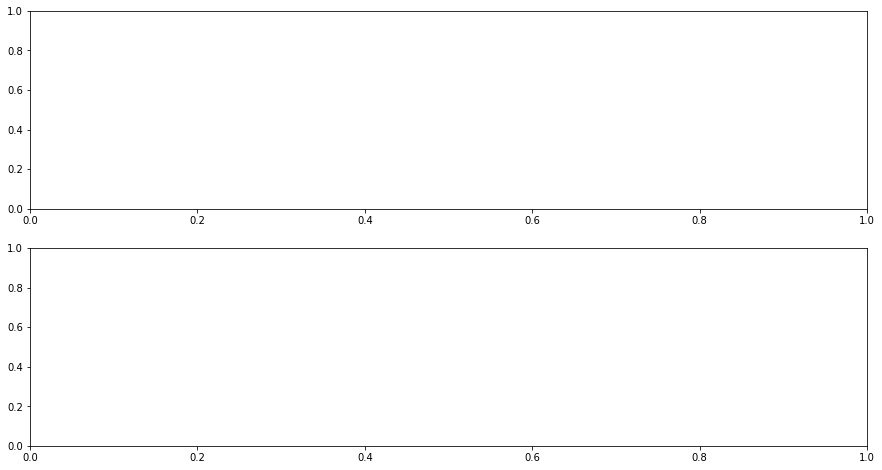

In [197]:
plt.rcParams['figure.figsize'] = (15, 8)
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True)

In [198]:
_ = ax1.plot(patches_denoised)
_ = ax2.plot(exp.reader[idxs[0][0]:idxs[-1][1]])

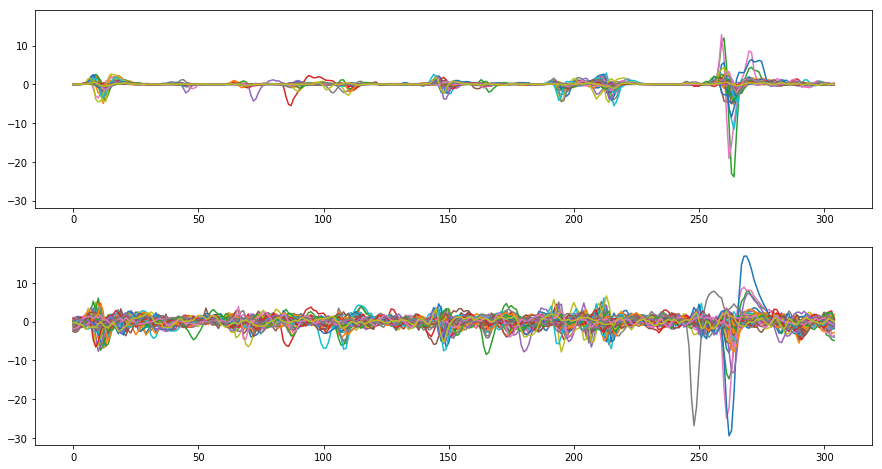

In [199]:
fig

In [136]:
with mlflow.start_run(experiment_id=EXPERIMENT_ID):
    name = reproducibility.make_filename(extension='h5')
    path = str(Path(path_to_data, 'denoiser', 'models', name))
    autoencoder.save(path)
    print('Saved {}'.format(name))
    
    mlflow.log_param('epoch', history.epoch)
    mlflow.log_param('history', history.history)
    mlflow.log_param('name', name)
    mlflow.log_param('kernel_size', kernel_size)
    mlflow.log_param('latent_dim', latent_dim)
    
    for name, value in history.params.items():
        mlflow.log_param(name, value)
    
    mlflow.log_param('epoch_last', history.epoch[-1])
    
    last_history = {name: value[-1] for name, value in history.history.items()}
    
    for name, value in last_history.items():
        mlflow.log_metric(name+'_last', value)

Saved 2018-10-01T05-30-57.h5
